In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

# Latent matrix from metadata

In [103]:
filename = '../data/10%sample/2019-Dec.csv_10%.csv'

In [104]:
!pwd

/Users/helena/code/sailormoonvicky/eCommerce/notebooks


In [105]:
import random
p = 0.01  # 1% of the lines
# keep the header, then take only 1% of lines
# if random from [0,1] interval is greater than 0.01 the row will be skipped
df = pd.read_csv(
         filename,
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p
)
df.shape

(67270, 9)

In [106]:
df.shape

(67270, 9)

In [107]:
df.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')

In [108]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-12-01 00:00:17 UTC,view,1004838,2232732093077520756,construction.tools.light,oppo,154.41,561593478,cc3328ce-e22a-49ba-b92a-3e143fb4b3d6
1,2019-12-01 00:06:47 UTC,view,3701244,2053013565983425517,appliances.environment.vacuum,elenberg,33.44,517251081,6ea72cb9-58f7-4034-9016-1a8d57b8b8d2
2,2019-12-01 00:20:24 UTC,view,10300052,2232732104888681081,apparel.scarf,bruder,70.09,544711482,b73f8cdc-5c53-474e-b444-2363cd7a1530
3,2019-12-01 00:23:35 UTC,view,100012194,2053013565228450757,apparel.shoes,respect,56.89,521463366,906c51ae-37b9-4c2b-9d79-98f0219db2b0
4,2019-12-01 00:36:46 UTC,view,14400051,2232732106943890077,appliances.kitchen.toster,axper,38.33,524179755,8a4ae53e-fa87-46bc-b8f9-bb3a8ec1390a


In [109]:
def preprocessing_feat(X, drop_event_time=False):
    if drop_event_time:
        X = X.drop("event_time", axis=1)
    
    X_preprocessed = X.dropna(subset = ['category_code', 'brand']) #tbd!!
    X_preprocessed = X_preprocessed.drop_duplicates()
    X_preprocessed['category_code'] = X_preprocessed['category_code'].str.replace('.',' ')
    return X_preprocessed

In [110]:
X_preprocessed = preprocessing_feat(df,  drop_event_time=True)

/var/folders/6f/vn_j9pqn1qd8rp92y6x0h0hh0000gn/T/ipykernel_9683/4055017079.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_preprocessed['category_code'] = X_preprocessed['category_code'].str.replace('.',' ')


In [111]:
X_preprocessed.shape

(53357, 8)

## Pricing criterion

In [112]:
def make_column(row):
    if row["price"] < row["25%"]:
        return "low"
    elif row["price"] < row["75%"]:
        return "medium"
    else:
        return "high"

def pricing_criterion(X):
    pricing_guide = X.groupby('category_code')['price'].describe()[["25%", "75%"]].reset_index()
    X_merged = X.merge(pricing_guide, on="category_code", how="right")
    X_merged["price_category"] = X_merged.apply(lambda row: make_column(row), axis=1)
    return X_merged


In [113]:
X_merged = pricing_criterion(X_preprocessed)

In [114]:
def metadata(X):
    X['metadata'] = X[['category_code', 'brand', 'price_category']].apply(lambda x: ' '.join(x), axis = 1)
    return X


In [115]:
X_meta = metadata(X_merged)
X_meta.nunique()

event_type            3
product_id        16305
category_id         708
category_code       134
brand              1928
price             11278
user_id           51199
user_session      53067
25%                 129
75%                 128
price_category        3
metadata           5921
dtype: int64

In [116]:
X_meta.set_index(X_meta['product_id'], inplace=True)

In [117]:
print(X_meta.shape)
X_meta.head()

(53357, 12)


,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,25%,75%,price_category,metadata
product_id,,,,,,,,,,,,
28400467,view,28400467,2232732097255047630,accessories bag,rieker,31.92,523646784,ec8e0915-176e-4c3f-bdb4-e9d9d90ab40b,28.31,73.88,medium,accessories bag rieker medium
25400106,view,25400106,2232732113596056386,accessories bag,internedoors,161.39,580098104,bbf64ee0-04ef-45d2-9ad5-9a8bf8a1eeea,28.31,73.88,high,accessories bag internedoors high
16200277,view,16200277,2232732108453839552,accessories bag,huggies,4.07,522288078,2ea540a5-abf0-4e4d-b176-8ff69c6d70cb,28.31,73.88,low,accessories bag huggies low
28401082,view,28401082,2053013566209917945,accessories bag,respect,46.59,538656313,5b469419-9fdd-4d59-9232-12ab7110afe0,28.31,73.88,medium,accessories bag respect medium
100006602,view,100006602,2232732097255047630,accessories bag,sportelite,483.92,571600267,ec7ad2ad-0e47-4d2f-9d79-5cb760f5d1da,28.31,73.88,high,accessories bag sportelite high


### Count Vectorizer

In [118]:
count = CountVectorizer()
count_matrix = count.fit_transform(X_meta['metadata'])
count_df_1 = pd.DataFrame(count_matrix.toarray(), index=X_meta.product_id.tolist())
print(count_df_1.shape)
count_df_1.head()

(53357, 2110)


,0,1,2,3,4,5,6,7,8,9,...,2100,2101,2102,2103,2104,2105,2106,2107,2108,2109
28400467,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25400106,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16200277,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28401082,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100006602,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [119]:
count_df_1 = count_df_1.reset_index()

In [120]:
len(list(set(count_df_1.index)))#.nunique()

53357

In [121]:
count_df_1.drop_duplicates(subset='index', keep='first', inplace=True) 
count_df_1["product_id"] = count_df_1["index"]
count_df_1.drop("index", axis=1, inplace=True)
count_df_1.head()

,0,1,2,3,4,5,6,7,8,9,...,2101,2102,2103,2104,2105,2106,2107,2108,2109,product_id
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,28400467
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,25400106
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16200277
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,28401082
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,100006602


### Dimensionality reduction

In [122]:
n = 50
svd = TruncatedSVD(n_components=n)
latent_df_1 = svd.fit_transform(count_df_1.set_index("product_id"))

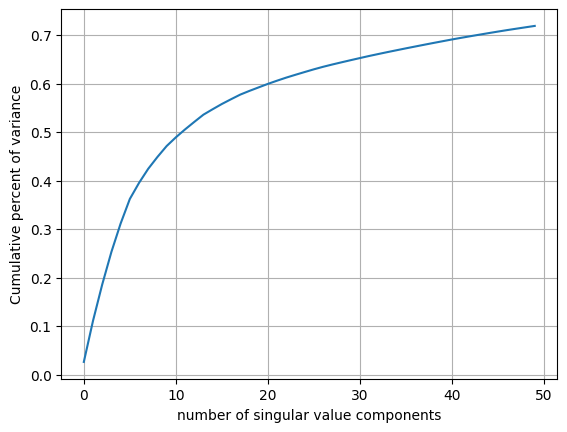

In [123]:
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('number of singular value components')
plt.ylabel('Cumulative percent of variance')   
plt.grid()
plt.show()

In [124]:
#count_df_1=count_df_1.set_index("product_id")
#count_df_1.head()
df_for_latent1 = count_df_1.product_id.tolist()

In [125]:
#n defined above
#n = 50
latent_df_1 = pd.DataFrame(latent_df_1[:,0:n], index=df_for_latent1)
print(latent_df_1.shape)
latent_df_1

(16305, 50)


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
28400467,0.783793,-0.493954,-0.253689,-0.053344,0.083249,0.047297,0.236744,0.104863,0.174329,0.008355,...,0.003819,0.008615,-0.056457,-0.043554,-0.005467,-0.024604,-0.025578,-0.017399,-0.029829,0.030390
25400106,0.247517,0.438223,0.210994,0.692802,0.357651,0.028916,0.263817,0.119686,0.209746,-0.016954,...,0.009251,-0.014502,-0.021676,-0.006969,0.000565,-0.011323,-0.026467,0.000541,-0.031314,0.016759
16200277,0.251934,0.405146,0.483534,-0.663709,0.091145,-0.016052,0.260152,0.107141,0.172639,-0.011771,...,-0.002364,0.012872,-0.017671,-0.012474,0.017085,-0.006416,-0.011498,0.003763,-0.002859,0.016950
28401082,0.802866,-0.510178,-0.236771,-0.050670,0.062712,0.048892,0.229945,0.105946,0.169042,0.009511,...,0.009994,0.007222,0.303218,0.168427,0.114573,0.064304,0.099692,0.107391,0.045930,-0.053190
100006602,0.248161,0.438193,0.211964,0.693177,0.357628,0.029229,0.264373,0.120124,0.211637,-0.018564,...,0.009322,-0.015088,-0.021717,-0.006887,-0.001793,-0.010320,-0.025688,-0.000030,-0.031926,0.016205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100058366,0.733272,-0.493487,-0.278258,-0.055213,0.050894,0.040289,0.127355,0.048588,0.059728,0.012747,...,-0.018841,-0.004408,-0.003777,-0.015619,-0.014697,0.013646,0.022885,0.005687,0.005665,0.015716
100058430,0.209296,0.397838,0.465679,-0.660894,0.049857,-0.023687,0.147035,0.048395,0.055437,-0.007529,...,-0.024603,0.003641,0.010876,-0.009808,-0.002118,0.017061,0.023534,0.009003,0.018602,0.018721
25510244,0.734559,-0.493436,-0.277725,-0.056226,0.051655,0.040476,0.133448,0.043673,0.061108,0.016825,...,-0.003920,0.005346,-0.006372,-0.015642,-0.018728,0.012665,0.023831,0.003677,0.005026,0.011201
4100348,0.733386,-0.493621,-0.278133,-0.055152,0.050750,0.040282,0.127290,0.048564,0.059695,0.012754,...,-0.018835,-0.004476,-0.003750,-0.015582,-0.014830,0.013620,0.022854,0.005610,0.005447,0.015783


In [126]:
latent_df_1.reset_index().drop_duplicates().shape

(16305, 51)

In [127]:
#X_meta['product_id'].nunique()

# Latent matrix from event types

In [128]:
def preprocessing_event(X):
    X_preprocessed = X.dropna(subset = ['category_code', 'brand']) #tbd!!
    X_preprocessed = X_preprocessed.drop_duplicates()
    return X_preprocessed

In [129]:
df_event = preprocessing_event(df)
df_event.user_id.nunique()

51199

In [130]:
dct = {'view': 1, 'cart': 3, 'purchase': 5}

In [131]:
df_event['rating'] = df_event['event_type'].map(dct)

In [132]:
df_event["rating"].sum()

63183

In [133]:
# df_rating.shape

In [134]:
# df_rating = df_event.pivot_table(values='rating',
#                                  index='product_id',
#                                  columns='user_id',
#                                  aggfunc="sum").fillna(0)
# df_rating

In [135]:
df_event.nunique()

event_time       52683
event_type           3
product_id       16305
category_id        708
category_code      134
brand             1928
price            11278
user_id          51199
user_session     53067
rating               3
dtype: int64

In [136]:
df_event.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,rating
0,2019-12-01 00:00:17 UTC,view,1004838,2232732093077520756,construction.tools.light,oppo,154.41,561593478,cc3328ce-e22a-49ba-b92a-3e143fb4b3d6,1
1,2019-12-01 00:06:47 UTC,view,3701244,2053013565983425517,appliances.environment.vacuum,elenberg,33.44,517251081,6ea72cb9-58f7-4034-9016-1a8d57b8b8d2,1
2,2019-12-01 00:20:24 UTC,view,10300052,2232732104888681081,apparel.scarf,bruder,70.09,544711482,b73f8cdc-5c53-474e-b444-2363cd7a1530,1
3,2019-12-01 00:23:35 UTC,view,100012194,2053013565228450757,apparel.shoes,respect,56.89,521463366,906c51ae-37b9-4c2b-9d79-98f0219db2b0,1
4,2019-12-01 00:36:46 UTC,view,14400051,2232732106943890077,appliances.kitchen.toster,axper,38.33,524179755,8a4ae53e-fa87-46bc-b8f9-bb3a8ec1390a,1


In [137]:
df_event.drop_duplicates(subset='product_id',inplace=True)
df_event.nunique()

event_time       16238
event_type           3
product_id       16305
category_id        708
category_code      134
brand             1927
price             6728
user_id          15883
user_session     16241
rating               3
dtype: int64

In [138]:
df_event.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,rating
0,2019-12-01 00:00:17 UTC,view,1004838,2232732093077520756,construction.tools.light,oppo,154.41,561593478,cc3328ce-e22a-49ba-b92a-3e143fb4b3d6,1
1,2019-12-01 00:06:47 UTC,view,3701244,2053013565983425517,appliances.environment.vacuum,elenberg,33.44,517251081,6ea72cb9-58f7-4034-9016-1a8d57b8b8d2,1
2,2019-12-01 00:20:24 UTC,view,10300052,2232732104888681081,apparel.scarf,bruder,70.09,544711482,b73f8cdc-5c53-474e-b444-2363cd7a1530,1
3,2019-12-01 00:23:35 UTC,view,100012194,2053013565228450757,apparel.shoes,respect,56.89,521463366,906c51ae-37b9-4c2b-9d79-98f0219db2b0,1
4,2019-12-01 00:36:46 UTC,view,14400051,2232732106943890077,appliances.kitchen.toster,axper,38.33,524179755,8a4ae53e-fa87-46bc-b8f9-bb3a8ec1390a,1


In [139]:
%%time

df_rating = df_event.pivot(values='rating',
               index='product_id',
               columns='user_id').fillna(0)

df_rating

CPU times: user 1.01 s, sys: 939 ms, total: 1.95 s
Wall time: 2.7 s


user_id,254777926,266712353,273665422,299809476,301597705,306627807,314102803,319456165,330207184,346529248,...,595314112,595321817,595326514,595350619,595358820,595368522,595373358,595389139,595390830,595406900
product_id,,,,,,,,,,,,,,,,,,,,,
1000894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1002062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100062704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100063161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100063286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [140]:
#df_rating.sum().reset_index()[0].sum()

17857.0

In [141]:
df_rating.head()

user_id,254777926,266712353,273665422,299809476,301597705,306627807,314102803,319456165,330207184,346529248,...,595314112,595321817,595326514,595350619,595358820,595368522,595373358,595389139,595390830,595406900
product_id,,,,,,,,,,,,,,,,,,,,,
1000894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1002062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [142]:
df_event.groupby("user_id").agg({"rating":sum}).sort_values(by="rating").sum()

rating    17857
dtype: int64

In [143]:
df_event.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,rating
0,2019-12-01 00:00:17 UTC,view,1004838,2232732093077520756,construction.tools.light,oppo,154.41,561593478,cc3328ce-e22a-49ba-b92a-3e143fb4b3d6,1
1,2019-12-01 00:06:47 UTC,view,3701244,2053013565983425517,appliances.environment.vacuum,elenberg,33.44,517251081,6ea72cb9-58f7-4034-9016-1a8d57b8b8d2,1
2,2019-12-01 00:20:24 UTC,view,10300052,2232732104888681081,apparel.scarf,bruder,70.09,544711482,b73f8cdc-5c53-474e-b444-2363cd7a1530,1
3,2019-12-01 00:23:35 UTC,view,100012194,2053013565228450757,apparel.shoes,respect,56.89,521463366,906c51ae-37b9-4c2b-9d79-98f0219db2b0,1
4,2019-12-01 00:36:46 UTC,view,14400051,2232732106943890077,appliances.kitchen.toster,axper,38.33,524179755,8a4ae53e-fa87-46bc-b8f9-bb3a8ec1390a,1


In [144]:
df_rating.reset_index()

user_id,product_id,254777926,266712353,273665422,299809476,301597705,306627807,314102803,319456165,330207184,...,595314112,595321817,595326514,595350619,595358820,595368522,595373358,595389139,595390830,595406900
0,1000894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1000978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1001588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1001605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1002062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16300,100062704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16301,100063161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16302,100063286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16303,100063441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [145]:
df_rating.head()

user_id,254777926,266712353,273665422,299809476,301597705,306627807,314102803,319456165,330207184,346529248,...,595314112,595321817,595326514,595350619,595358820,595368522,595373358,595389139,595390830,595406900
product_id,,,,,,,,,,,,,,,,,,,,,
1000894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1002062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
svd = TruncatedSVD(n_components=75)
latent_df_2 = svd.fit_transform(df_rating)

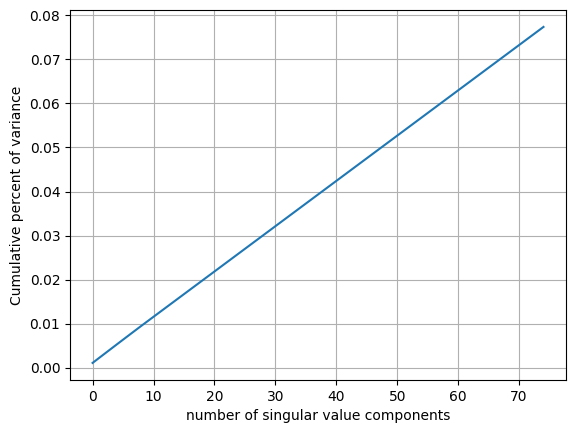

In [43]:
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('number of singular value components')
plt.ylabel('Cumulative percent of variance')   
plt.grid()
plt.show()

In [44]:
latent_df_2 = pd.DataFrame(latent_df_2, index=df_rating.reset_index().product_id.tolist())
latent_df_2.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
1000978,-1.755592e-10,-1.642510e-11,1.923479e-10,4.466441e-10,-1.370419e-10,2.323831e-10,1.430732e-10,4.099325e-10,8.379258e-11,7.704415e-12,...,-6.677088e-10,1.039563e-10,5.239470e-10,2.192336e-10,-8.690099e-11,-9.331917e-10,-7.965568e-11,1.210182e-09,-3.730708e-10,9.671213e-10
1001588,-4.681038e-10,-3.530410e-10,1.638851e-10,-2.055734e-10,8.681690e-10,-6.583311e-11,1.375846e-11,3.106668e-10,1.870028e-11,-4.590210e-11,...,8.333494e-10,5.365818e-10,7.511552e-10,-5.126553e-10,6.547225e-10,8.307190e-10,1.891668e-12,9.427031e-10,-2.478777e-10,-9.084511e-10
1001605,-4.233679e-10,-8.649615e-11,2.944951e-10,-2.131103e-10,-4.456747e-11,9.000622e-11,-9.006956e-11,-3.933146e-10,-1.892179e-10,1.157211e-11,...,2.851314e-10,-3.812119e-10,-2.326549e-10,2.812894e-11,4.531195e-10,1.881696e-10,-4.402595e-10,6.077411e-10,-7.100309e-10,3.297403e-10
1001606,-4.578245e-10,3.577646e-10,-1.502022e-10,-6.245423e-10,-3.532893e-10,-2.444438e-10,6.619000e-11,1.442931e-10,-1.409303e-12,4.600580e-11,...,3.280216e-10,3.461385e-10,6.765983e-13,7.275110e-10,1.027114e-10,5.054022e-10,-3.132060e-10,1.590300e-10,2.260735e-10,-1.073553e-09
1001618,2.969520e-10,-3.665897e-10,6.231369e-11,-8.524225e-10,-1.196741e-10,-2.110978e-10,2.218163e-11,1.807997e-10,6.236055e-10,2.390682e-11,...,-2.126524e-11,-1.939873e-10,5.421713e-10,1.619853e-10,1.639195e-10,-1.023123e-10,-4.456944e-11,-4.095008e-10,-7.073503e-10,6.157830e-10


In [45]:
latent_df_2.shape

(16184, 75)

# Apply Cosine Similarity in Content and Collaborative Matrices


In [46]:
product_id=5100337

In [47]:
# Get the latent vectors for "Toy Story" from content and collaborative matrices
v1 = np.array(latent_df_1.loc[product_id]).reshape(1, -1)
v2 = np.array(latent_df_2.loc[product_id]).reshape(1, -1)

# Compute the cosine similarity of this movie with the others in the list
sim1 = cosine_similarity(latent_df_1, v1).reshape(-1)
sim2 = cosine_similarity(latent_df_2, v2).reshape(-1)

In [48]:
dictDf_1 = {'features': sim1} 
recommendation_df_1 = pd.DataFrame(dictDf_1, index = latent_df_1.index)
# recommendation_df_1.sort_values('features', ascending=False, inplace=True)

In [49]:
dictDf_2 = {'ratings': sim2} 
recommendation_df_2 = pd.DataFrame(dictDf_2, index = latent_df_2.index)
# recommendation_df_2.sort_values('ratings', ascending=False, inplace=True)

In [50]:
weight_features = 0.8

In [51]:
recommendation_combined = pd.merge(recommendation_df_1, recommendation_df_2, left_index=True, right_index=True)
recommendation_combined['hybrid'] = ((weight_features*recommendation_combined['features'] + (1-weight_features)*recommendation_combined['ratings']))

In [52]:
recommendation_combined.sort_values('ratings', ascending=False, inplace=True)
recommendation_combined

,features,ratings,hybrid
5100337,1.000000,1.000000,1.000000
57000020,0.318414,0.513242,0.357379
7202907,0.234819,0.457585,0.279372
12705141,0.295333,0.443916,0.325050
1304644,0.451505,0.432364,0.447677
...,...,...,...
100039909,0.258454,-0.414766,0.123810
5100715,0.581726,-0.419639,0.381453
5000629,0.298117,-0.442725,0.149948
1200519,0.283973,-0.446657,0.137847


In [53]:
recommendation_combined.head()

,features,ratings,hybrid
5100337,1.000000,1.000000,1.000000
57000020,0.318414,0.513242,0.357379
7202907,0.234819,0.457585,0.279372
12705141,0.295333,0.443916,0.325050
1304644,0.451505,0.432364,0.447677


In [54]:
def top_n_products(product_id, rec_df, meta_df, n=10, ranking='hybrid'):
    
    """Valid inouts for ranking: 'features', 'ratings', 'hybrid'"""
    
    feat_idx = rec_df.sort_values(ranking, ascending=False).index[0:n]
    counter = 0
    
    for i in feat_idx:
        meta_text = meta_df[meta_df['product_id'] == i][['metadata']].iloc[0,:][0]
        
        if counter == 0:
            print(f"Top {n} recommendations for product_id {product_id}:")
            print(f"{i} - {meta_text} \n")
#             print("-----------------------")

        else:
            print(f"Rec {counter}) {i} - {meta_text}")
        
        counter += 1

In [55]:
top_n_products(1002532, recommendation_combined, X_meta, ranking='features')

Top 10 recommendations for product_id 1002532:
5100337 - electronics clocks apple medium 

Rec 1) 5100562 - electronics clocks apple medium
Rec 2) 5100604 - electronics clocks apple medium
Rec 3) 5100505 - electronics clocks apple medium
Rec 4) 5100338 - electronics clocks apple medium
Rec 5) 5100610 - electronics clocks apple medium
Rec 6) 5100351 - electronics clocks apple medium
Rec 7) 5100689 - electronics clocks apple medium
Rec 8) 3901108 - electronics clocks artel medium
Rec 9) 3900775 - electronics clocks artel medium


In [56]:
top_n_products(1002532, recommendation_combined, X_meta, ranking='ratings')

Top 10 recommendations for product_id 1002532:
5100337 - electronics clocks apple medium 

Rec 1) 57000020 - appliances personal scales crown medium
Rec 2) 7202907 - furniture living_room chair lego medium
Rec 3) 12705141 - computers desktop maxxis medium
Rec 4) 1304644 - electronics audio headphone apple high
Rec 5) 21409270 - electronics clocks casio low
Rec 6) 100014615 - appliances personal massager dexp medium
Rec 7) 1801806 - appliances personal massager artel low
Rec 8) 10900186 - appliances kitchen mixer kitchenaid high
Rec 9) 55700126 - apparel trousers weekend high


In [57]:
top_n_products(1002532, recommendation_combined, X_meta, ranking='hybrid')

Top 10 recommendations for product_id 1002532:
5100337 - electronics clocks apple medium 

Rec 1) 5100338 - electronics clocks apple medium
Rec 2) 5100689 - electronics clocks apple medium
Rec 3) 5100351 - electronics clocks apple medium
Rec 4) 5100562 - electronics clocks apple medium
Rec 5) 5100505 - electronics clocks apple medium
Rec 6) 5100610 - electronics clocks apple medium
Rec 7) 21403909 - electronics clocks orient medium
Rec 8) 100040910 - electronics clocks tissot medium
Rec 9) 21400427 - electronics clocks boccia medium
